In [1]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch import nn

## DataSet

In [2]:
class myDataset(Dataset):
    def __init__(self, data_dir, segment_len=128):
        self.data_dir = data_dir
        self.segment_len = segment_len
        
        mapping_path = Path(data_dir+ '/mapping.json') 
        mapping = json.load(mapping_path.open())
        self.speaker2id = mapping["speaker2id"]
        
        metadata_path = Path(data_dir+ '/metadata.json')
        metadata = json.load(open(metadata_path))["speakers"]
        self.speaker_num = len(metadata.keys())
        self.data = []
        
        for speaker in metadata.keys():
            for uttr in metadata[speaker]:
                self.data.append((uttr['feature_path'],self.speaker2id[speaker]))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        feat_path, speaker = self.data[index]
        mel = torch.load(os.path.join(self.data_dir, feat_path))
        
        if len(mel) > self.segment_len:
            start = random.randint(0,len(mel)-self.segment_len)
            mel = mel[start:start+self.segment_len]
            
        speaker = torch.FloatTensor([speaker])
        return mel,speaker
    
    def get_speaker_number(self):
        return self.speaker_num
            
            
        

## DataLoader

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
    mel, speaker = zip(*batch)
    
    mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) which is very small value.
    
    return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size):
    dataset = myDataset(data_dir)
    speaker_num = dataset.get_speaker_number()
    # Split dataset into training dataset and validation dataset
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset) - trainlen]
    trainset, validset = random_split(dataset, lengths)

    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        collate_fn=collate_batch,
    )
    valid_loader = DataLoader(
        validset,
        batch_size=batch_size,
        drop_last=True,
        pin_memory=True,
        collate_fn=collate_batch,
    )

    return train_loader, valid_loader, speaker_num

In [4]:
data_dir = 'data/Dataset'
batch_size = 32

train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size)

## Model

In [5]:
class Classifier(nn.Module):
    def __init__(self,d_model=80, n_spks=600, dropout=.1):
        super().__init__()
        
        self.prenet = nn.Linear(40, d_model)
        
        self.drop = nn.Dropout1d(p=dropout)
        
        self.feedforward_1 = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model,d_model),
            nn.ReLU(),
            nn.Dropout1d(p=dropout),
            nn.Linear(d_model,d_model),
            nn.Dropout1d(p=dropout),
        )
        
        self.transformer = nn.TransformerEncoderLayer(
            d_model=d_model, dim_feedforward=256, nhead=1
        )
                
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(128, 128, 3, 1, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout1d(p=dropout)
        )
        
        self.feedforward_2 = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model,d_model),
            nn.ReLU(),
            nn.Dropout1d(p=dropout),
            nn.Linear(d_model,d_model),
            nn.Dropout1d(p=dropout),
        )
            
        self.norm = nn.LayerNorm(d_model)
            
        self.pred_Layer = nn.Sequential(
            nn.Linear(d_model,n_spks),
        )
        
    def forward(self, x):
        
        pre = self.prenet(x)
        
        x_0 = self.drop(pre)
        
        x_1_1 = self.feedforward_1(x_0)
        x_1_2 = x_0
        x_1 = x_1_1*0.5+x_1_2
                
        x_2_1 = self.transformer(x_1.permute(1,0,2))
        x_2_2 = x_1.permute(1,0,2)
        x_2 = x_2_1+x_2_2
                        
        x_3_1 = self.cnn_layers(x_2.permute(1,0,2))
        x_3_2 = x_2.transpose(0, 1)
        x_3 = x_3_1+x_3_2
        
        x_4_1 = self.feedforward_2(x_3)
        x_4_2 = x_3
        x_4 = x_4_1*0.5+x_4_2

        stats = self.norm(x_4)
        
        out = self.pred_Layer(stats)
        
        out = out.mean(dim=1)
        
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier(n_spks=speaker_num).to(device)

#model.load_state_dict(torch.load('HW4-3.pth'))

## Learning rate schedule

In [6]:
import math
import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_schedule_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    def lr_lamda(current_epoch):
        if current_epoch < num_warmup_steps:
            return float(current_epoch) / float(max(1,num_warmup_steps))
        
        progress = float(current_epoch-num_warmup_steps)/float(max(1,num_training_steps-num_warmup_steps))
        return max(0.0,0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    return LambdaLR(optimizer, lr_lamda, last_epoch)

## Model Funtion

In [7]:
def model_fn(batch, model, criterion, device):
    
    mels, labels = batch
    mels = mels.to(device)
    labels = labels.to(device)
    
    outs = model(mels)
    
    loss = criterion(outs, labels)
    
    preds = outs.argmax(1)
    
    acc = torch.mean((preds == labels).float())
    
    return loss, acc

In [8]:
from tqdm.auto import tqdm
import torch

def train(dataloader, model, optimizer, scheduler,criterion, device):
    pbar = tqdm(dataloader,desc="Train")
    loss_li = []
    acc_li = []
    for i,x in enumerate(pbar):
        loss, acc = model_fn(x, model, criterion, device)
        mean_loss,mean_acc = loss.item(),acc.item()
        loss_li.append(mean_loss)
        acc_li.append(mean_acc)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        
        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
            {'trainning loss':f"{mean_loss:.2f}",
            'trainning accuracy':f"{mean_acc:.4f}",
            'process':i/len(dataloader)*100}
        )
    return sum(loss_li)/len(loss_li),sum(acc_li)/len(acc_li)
        

def valid(dataloader, model, criterion, device): 
    """Validate on validation set."""

    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    pbar = tqdm(dataloader, desc="Valid")

    for i, batch in enumerate(pbar):
        with torch.no_grad():
            loss, accuracy = model_fn(batch, model, criterion, device)
            running_loss += loss.item()
            running_accuracy += accuracy.item()

        pbar.update(dataloader.batch_size)
        pbar.set_postfix(
            {'vailding loss':f"{running_loss/ len(dataloader)}",
            'vailding accuracy':f"{running_accuracy/ len(dataloader)}",}
        )

    model.train()

    return running_accuracy / len(dataloader)

## Main

[Info]: Use cuda now!
[Epoch: 1 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.14000706214689265]
[Epoch: 2 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.2662429378531073]
[Epoch: 3 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.3290960451977401]
[Epoch: 4 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.3894774011299435]
[Epoch: 5 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.4244350282485876]
[Epoch: 6 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.4593926553672316]
[Epoch: 7 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.4738700564971751]
[Epoch: 8 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.4959392655367232]
[Epoch: 9 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5132415254237288]
[Epoch: 10 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5238347457627118]
[Epoch: 11 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5492584745762712]
[Epoch: 12 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5489053672316384]
[Epoch: 13 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.549611581920904]
[Epoch: 14 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5568502824858758]
[Epoch: 15 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.554731638418079]
[Epoch: 16 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.55420197740113]
[Epoch: 17 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.570268361581921]
[Epoch: 18 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5637358757062146]
[Epoch: 19 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5803319209039548]
[Epoch: 20 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5858050847457628]
[Epoch: 21 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.571680790960452]
[Epoch: 22 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5796257062146892]
[Epoch: 23 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.5748587570621468]
[Epoch: 24 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6034604519774012]
[Epoch: 25 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6147598870056498]
[Epoch: 26 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.625882768361582]
[Epoch: 27 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6442443502824858]
[Epoch: 28 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6398305084745762]
[Epoch: 29 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6419491525423728]
[Epoch: 30 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.655367231638418]
[Epoch: 31 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6613700564971752]
[Epoch: 32 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.657132768361582]
[Epoch: 33 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.661723163841808]
[Epoch: 34 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6581920903954802]
[Epoch: 35 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6513064971751412]
[Epoch: 36 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.659427966101695]
[Epoch: 37 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6521892655367232]
[Epoch: 38 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6633121468926554]
[Epoch: 39 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.658545197740113]
[Epoch: 40 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6649011299435028]
[Epoch: 41 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6500706214689266]
[Epoch: 42 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6431850282485876]
[Epoch: 43 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6400070621468926]
[Epoch: 44 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6440677966101694]
[Epoch: 45 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.644774011299435]
[Epoch: 46 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.621822033898305]
[Epoch: 47 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6352401129943502]
[Epoch: 48 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.649364406779661]
[Epoch: 49 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6377118644067796]
[Epoch: 50 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6431850282485876]
[Epoch: 51 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6276483050847458]
[Epoch: 52 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.647069209039548]
[Epoch: 53 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.653072033898305]
[Epoch: 54 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6827330508474576]
[Epoch: 55 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6719632768361582]
[Epoch: 56 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6802612994350282]
[Epoch: 57 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6790254237288136]
[Epoch: 58 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6684322033898306]
[Epoch: 59 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6859110169491526]
[Epoch: 60 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.686087570621469]
[Epoch: 61 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6938559322033898]
[Epoch: 62 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6887358757062146]
[Epoch: 63 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6915607344632768]
[Epoch: 64 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6781426553672316]
[Epoch: 65 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6864406779661016]
[Epoch: 66 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6844985875706214]
[Epoch: 67 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6846751412429378]
[Epoch: 68 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6862641242937854]
[Epoch: 69 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.686617231638418]
[Epoch: 70 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6822033898305084]
[Epoch: 71 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6781426553672316]
[Epoch: 72 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6597810734463276]
[Epoch: 73 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.661723163841808]
[Epoch: 74 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6583686440677966]
[Epoch: 75 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6574858757062146]
[Epoch: 76 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.654837570621469]
[Epoch: 77 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.678319209039548]
[Epoch: 78 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.667725988700565]
[Epoch: 79 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6652542372881356]
[Epoch: 80 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.676906779661017]
[Epoch: 81 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.665430790960452]
[Epoch: 82 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.684322033898305]
[Epoch: 83 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.689795197740113]
[Epoch: 84 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7016242937853108]
[Epoch: 85 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.703566384180791]
[Epoch: 86 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.713276836158192]
[Epoch: 87 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6949152542372882]
[Epoch: 88 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7062146892655368]
[Epoch: 89 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6982697740112994]
[Epoch: 90 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.692973163841808]
[Epoch: 91 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6954449152542372]
[Epoch: 92 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7048022598870056]
[Epoch: 93 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6927966101694916]
[Epoch: 94 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7055084745762712]
[Epoch: 95 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6987994350282486]
[Epoch: 96 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6903248587570622]
[Epoch: 97 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.69579802259887]
[Epoch: 98 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6857344632768362]
[Epoch: 99 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6762005649717514]
[Epoch: 100 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6859110169491526]
[Epoch: 101 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6615466101694916]
[Epoch: 102 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6864406779661016]
[Epoch: 103 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6649011299435028]
[Epoch: 104 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.657662429378531]
[Epoch: 105 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6834392655367232]
[Epoch: 106 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.659957627118644]
[Epoch: 107 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6705508474576272]
[Epoch: 108 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6776129943502824]
[Epoch: 109 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6647245762711864]
[Epoch: 110 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6800847457627118]
[Epoch: 111 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.680614406779661]
[Epoch: 112 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6931497175141242]
[Epoch: 113 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7076271186440678]
[Epoch: 114 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7138064971751412]
[Epoch: 115 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7014477401129944]
[Epoch: 116 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7191031073446328]
[Epoch: 117 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7093926553672316]
[Epoch: 118 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7067443502824858]
[Epoch: 119 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7122175141242938]
[Epoch: 120 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7125706214689266]
[Epoch: 121 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.701271186440678]
[Epoch: 122 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7111581920903954]
[Epoch: 123 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7097457627118644]
[Epoch: 124 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7000353107344632]
[Epoch: 125 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7021539548022598]
[Epoch: 126 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6993290960451978]
[Epoch: 127 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6936793785310734]
[Epoch: 128 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.691207627118644]
[Epoch: 129 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6687853107344632]
[Epoch: 130 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.666843220338983]
[Epoch: 131 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6873234463276836]
[Epoch: 132 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6717867231638418]
[Epoch: 133 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6786723163841808]
[Epoch: 134 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6871468926553672]
[Epoch: 135 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.685204802259887]
[Epoch: 136 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6774364406779662]
[Epoch: 137 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.686087570621469]
[Epoch: 138 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6862641242937854]
[Epoch: 139 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.6880296610169492]
[Epoch: 140 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7076271186440678]
[Epoch: 141 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7131002824858758]
[Epoch: 142 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.712747175141243]
[Epoch: 143 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7175141242937854]
[Epoch: 144 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7018008474576272]
[Epoch: 145 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7152189265536724]
[Epoch: 146 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7192796610169492]
[Epoch: 147 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7162782485875706]
[Epoch: 148 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7115112994350282]
[Epoch: 149 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7182203389830508]
[Epoch: 150 ]


Train:   0%|          | 0/1593 [00:00<?, ?it/s]

Valid:   0%|          | 0/177 [00:00<?, ?it/s]

[vaild_acc:0.7131002824858758]


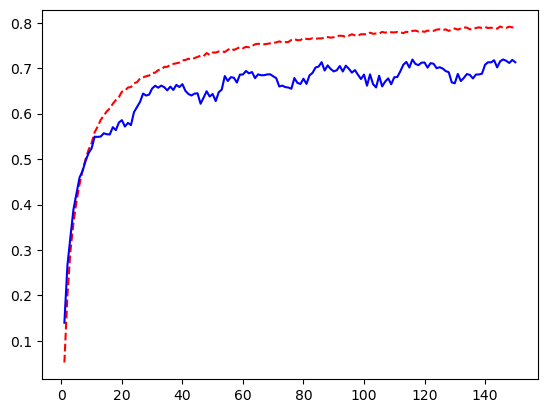

In [9]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt



data_dir= "data/Dataset"
batch_size= 32
warmup_steps= 50
total_steps= 150


print(f"[Info]: Use {device} now!")

train_loader, valid_loader, speaker_num = get_dataloader("data/Dataset", batch_size)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

train_acc = []
valid_acc = []

for i in range(total_steps):
    print(f"[Epoch: {i+1} ]")
    mean_loss,mean_acc = train(train_loader, model, optimizer, scheduler, criterion, device)
    acc = valid(valid_loader, model, criterion, device)
    print(f"[vaild_acc:{acc}]")
    train_acc.append(mean_acc)
    valid_acc.append(acc)

x = torch.linspace(1,len(train_acc),len(train_acc))
plt.plot(x,train_acc,'--r');
plt.plot(x,valid_acc,'b');


In [10]:
torch.save(model.state_dict(),'HW4-4.pth')